In [1]:
import tensorflow as tf
import fastai
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import Adam

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
num_classes = 7 #angry, disgusted, scared, happy, sad, surprised, neutral
batch_size = 256
epochs = 30

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
# open and read the data set
with open('Data/FER/fer2013.csv') as f:
    content = f.readlines()

lines = np.array(content)
num_of_images = lines.size # number of images the file has

In [8]:
num_of_images

35888

In [9]:
#initialize training and testing set
xtrain, ytrain, xtest, ytest = [], [], [], []

In [10]:
# the images (num_of_instances) are stored in numbers in the form of bits
# now we split the images into train and test sets
for i in range(1, num_of_images):
    emotion, img, usage = lines[i].split(",")
    valuelist = img.split(" ") # convert each imgage set number into a list of values
    pixels = np.array(valuelist, 'float32') # convert that list into an array
    emotion = keras.utils.to_categorical(emotion, num_classes)
    
    if 'Training' in usage:
        ytrain.append(emotion)
        xtrain.append(pixels)
        
    elif 'PublicTest' in usage:
        ytest.append(emotion)
        xtest.append(pixels)

In [11]:
# data transformation
xtrain = np.array(xtrain, 'float32')
ytrain = np.array(ytrain, 'float32')
xtest = np.array(xtest, 'float32')
ytest = np.array(ytest, 'float32')

# normalize between 0 and 1
xtrain /= 255
ytrain /= 255

In [12]:
xtrain.shape

(28709, 2304)

In [13]:
# Reshaping them to feed them into the CNN
# The 2D images are 48x48 and 1 channel
xtrain = xtrain.reshape(xtrain.shape[0], 48, 48, 1)
xtrain = xtrain.astype('float32')
xtest = xtest.reshape(xtest.shape[0], 48, 48, 1)
xtest = xtest.astype('float32')

print(xtrain.shape[0], 'train samples')
print(xtest.shape[0], 'test samples')

28709 train samples
3589 test samples


In [29]:
# CNN structure
model = Sequential()

# 1st convulutional layer
model.add(Conv2D(64, (5,5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2)))

# 2nd convolutional layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2,2)))

# 3rd convolutional layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2,2)))
          
model.add(Flatten())
          
# fully connected layers
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [30]:
# data loading
generator = ImageDataGenerator()
generator_train = generator.flow(xtrain, ytrain, batch_size=batch_size)

In [31]:
# training
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [32]:
fit = False # For the first run fit = True. On subsequent runs set fit = False
if fit == True: # train a randonmly selected batch
    # This trains the model using the number of epochs and the batch size
    model.fit_generator(generator_train, steps_per_epoch=batch_size, epochs=epochs)
else:
    model.load_weights('trained-model.h5')

Epoch 1/30
256/256 [==============================] - 6s 22ms/step - loss: 0.0071 - acc: 0.2518
Epoch 2/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0064 - acc: 0.3508
Epoch 3/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0056 - acc: 0.4424
Epoch 4/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0052 - acc: 0.4959
Epoch 5/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0048 - acc: 0.5325
Epoch 6/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0045 - acc: 0.5585
Epoch 7/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0043 - acc: 0.5873
Epoch 8/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0041 - acc: 0.6030
Epoch 9/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0039 - acc: 0.6257
Epoch 10/30
256/256 [==============================] - 5s 19ms/step - loss: 0.0037 - acc: 0.6516
Epoch 11/30
256/256 [==================

In [33]:
model.save('trained-model.h5')

In [34]:
# Evaluation
train_score = model.evaluate(xtrain, ytrain, verbose=0)
print('Training loss:', train_score[0])
print('Training accuracy (%):', 100*train_score[1])

test_score = model.evaluate(xtest, ytest, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy (%):', 100*test_score[1])

Training loss: 0.0003389973800183249
Training accuracy (%): 97.3004981016406
Test loss: 9.246350116203608
Test accuracy (%): 42.29590415240463


In [36]:
predictions = model.predict(xtest)

In [37]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix

pred_list = []
actual_list = []

for i in predictions:
    pred_list.append(np.argmax(i))
    
for i in ytest:
    actual_list.append(np.argmax(i))
    
confusion_matrix(actual_list, pred_list)

array([[141,  14,  81,  52,  29,  67,  83],
       [ 15,  12,   9,   8,   1,   5,   6],
       [ 50,   5, 147,  51,  52, 124,  67],
       [ 50,   6,  63, 594,  17, 111,  54],
       [ 54,   7, 113, 105, 112, 116, 146],
       [  8,   0,  53,  25,   9, 307,  13],
       [ 38,   3,  83,  92,  53, 133, 205]])

In [38]:
# function that draws bar chart for emotion predictions
def emotion_analysis(emotions):
    classes = ('angry', 'disgusted', 'scared', 'happy', 'sad', 'surprised', 'neutral')
    y_pos = np.arange(len(classes))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, classes)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

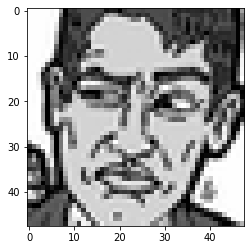

[0. 0. 0. 0. 0. 1. 0.]


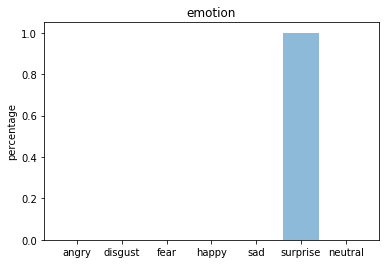

----------------------------------------------


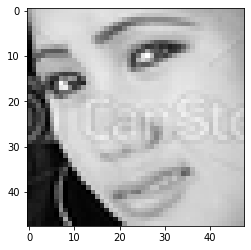

[0. 0. 0. 0. 0. 1. 0.]


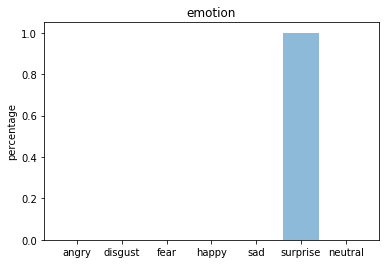

----------------------------------------------


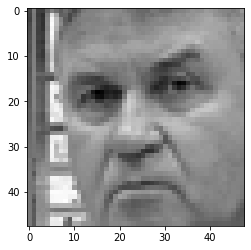

[0. 0. 1. 0. 0. 0. 0.]


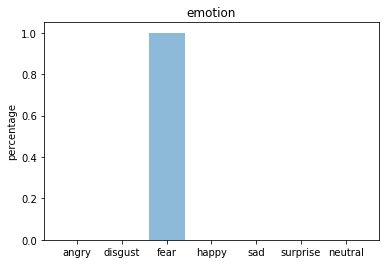

----------------------------------------------


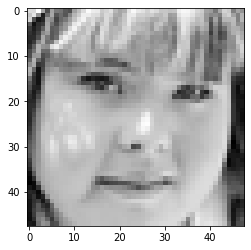

[0. 0. 0. 1. 0. 0. 0.]


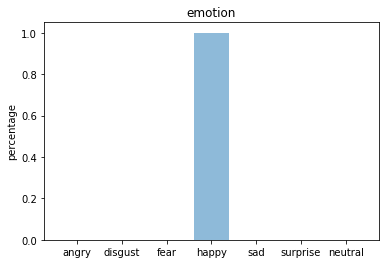

----------------------------------------------


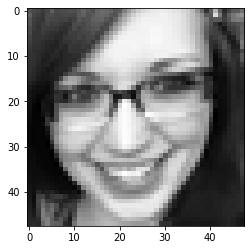

[0. 0. 0. 1. 0. 0. 0.]


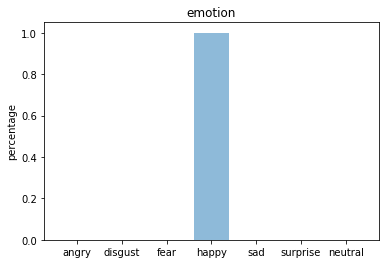

----------------------------------------------


In [39]:
# This is a monitor for our test results to know if our test results are good or not
monitor_testset_results = True

if monitor_testset_results == True:
    # make predictions for test set
    predictions = model.predict(xtest)

    index = 0
    for i in predictions:
        if index < 5:
            testing_img = np.array(xtest[index], 'float32')
            testing_img = testing_img.reshape([48, 48]);

            plt.gray()
            plt.imshow(testing_img)
            plt.show()
            
            print(i)

            emotion_analysis(i)
            print("----------------------------------------------")
        index = index + 1

In [ ]:
from keras.models import load_model
model = load_model('trained-model.h5')

### Checking with an uploaded image

In [15]:
# file = 'photo.jpg' # image that is loaded to test
# true_image = image.load_img(file)
# img = image.load_img(file, grayscale=True, target_size=(48, 48))

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

In [ ]:
custom = model.predict(x)
x = x.reshape([48,48])

In [16]:
# plt.gray()
# plt.imshow(true_image)
# plt.show()

## Detecting emotion on webcam

In [2]:
# Importing libraries
from keras.preprocessing.image import img_to_array
import imutils
import cv2
from keras.models import load_model
import numpy as np

In [3]:
# directory of where your CV2 data files are stored
cascade_file_path = 'C:\ProgramData\Anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml'
emotion_model_path = 'trained-model.h5'

In [4]:
# hyper-parameters for bounding boxes shape

# CascadeClassifier: 0object detection module from the open CV library
face_detection  = cv2.CascadeClassifier(cascade_file_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
emotions = ['angry', 'disgusted', 'scared', 'happy', 'sad', 'suprised', 'neutral']

In [7]:
from keras.preprocessing.image import img_to_array
import imutils # image utilities
import cv2 # OpenCV
from keras.models import load_model
import numpy as np

# parameters for loading data and images
detection_model_path = 'C:\ProgramData\Anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml'
emotion_model_path = 'trained-model.h5'

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised",
 "neutral"]


# starting video stream
cv2.namedWindow('Facial Expression Detection')  # This will return video from the first webcam on your computer. 
camera = cv2.VideoCapture(0)

# This code initiates an infinite loop (to be broken later by a break statement), 
# where we have ret and frame being defined as the camera.read().
while True:
    frame = camera.read()[1] # frame is each frame that is returned
    frame = imutils.resize(frame,width=400) # Resizing the frame to have a width of 450 pixels.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # We define a new variable, gray, as the frame, converted to gray.
    faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),
                                            flags=cv2.CASCADE_SCALE_IMAGE)
    
    canvas = np.zeros((250, 300, 3), dtype="uint8")
    frameClone = frame.copy()
    if len(faces) > 0:
        faces = sorted(faces, reverse=True, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
        (fX, fY, fW, fH) = faces
        # Extract the ROI of the face from the grayscale image, resize it to a fixed 48x48 pixels, and then prepare
        # the ROI for classification via the CNN
        roi = gray[fY:fY + fH, fX:fX + fW] # region of images
        roi = cv2.resize(roi, (48, 48))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]

 
    for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
                # construct the label text
                text = "{}: {:.2f}%".format(emotion, prob * 100)
                w = int(prob * 300)
                cv2.rectangle(canvas, (7, (i * 35) + 5),
                (w, (i * 35) + 35), (0, 0, 255), -1)
                cv2.putText(canvas, text, (10, (i * 35) + 23),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45,
                (255, 255, 255), 2)
                cv2.putText(frameClone, label, (fX, fY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
                cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
                              (0, 0, 255), 2)
    # imshow displays an image in the specified window
    cv2.imshow('Facial Expression Detection', frameClone)
    cv2.imshow("Emotion", canvas)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # if we get a key, and that key is a q, we will exit the while loop with a break, which then runs:   
camera.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 